# Exploratory Data Analysis

## Introduction

## 0 - Imports and Definitions

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import hvplot.pandas


def grade_to_score(grade, sub_grade):
    # Extract the numeric part of sub_grade
    sub_grade_num = int(''.join(filter(str.isdigit, sub_grade)))

    # Assign numerical values to grades (A=0, B=1, ..., G=6)
    grade_value = ord(grade.upper()) - ord('A')

    # Total number of combinations (7 grades * 5 sub-grades)
    total_combinations = 7 * 5

    # Calculate the score
    score = (grade_value * 5 + (sub_grade_num - 1)) / (total_combinations - 1)

    return 1 - score

def home_ownership_to_score(home_ownership):
    if home_ownership == 'RENT':
        return 1
    elif home_ownership == 'MORTGAGE':
        return 2
    elif home_ownership == 'OWN':
        return 3
    return 0
    
def transform_type(TYPE):
    if TYPE == 'INT':
        return 'int64'
    elif TYPE == 'REAL':
        return 'float64'
    else:
        return 'object'
    
def loan_status_to_int(status):
    if status == 'Charged Off':
        return 0
    if status == 'Fully Paid':
        return 1
    else:
        return -1

database_file = '../data/All_Lending_Club_Loan_2007_2018.sqlite'

columns_of_interest = ['id', 'loan_amnt', 'term_months', 'int_rate', 'installment', 'grade', 'sub_grade',
                       'home_ownership', 'annual_inc', 'verification_status',
                       'issue_d_unix', 'loan_status', 'purpose', 'dti', 'earliest_cr_line', 
                       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
                       'application_type', 'mort_acc', 'pub_rec_bankruptcies']

tag = 'prototype'

## 1 - Loading data and defining columns

In [ ]:
print("Loading Data")
# Defining the connection to the database
conn = sqlite3.connect(database_file)

# Loading descriptions into dataframe
description_fetch_query = f"""SELECT *
                    FROM descriptions
                    """
descriptions = pd.read_sql_query(description_fetch_query, conn, index_col = 'name')

column_types = {idx:transform_type(row['data_type']) for idx, row in descriptions.iterrows() if row['location'] == 'loans_data' and idx in columns_of_interest}

conditions_string = f'WHERE {columns_of_interest[0]} IS NOT NULL ' + ' '.join([f'AND {col} IS NOT NULL' for col in columns_of_interest[1:]])
# Loading data into dataframe
data_fetch_query = f"""SELECT {', '.join(columns_of_interest)} 
                       FROM loans_data
                       {conditions_string}
                       ORDER BY RANDOM()"""
loans_data = pd.read_sql_query(data_fetch_query, conn, index_col='id', dtype=column_types)

# Closing connection
conn.close()

#------------- Temporary -------------
loans_data['mort_acc'] = loans_data['mort_acc'].astype('float').astype('int')
loans_data['pub_rec_bankruptcies'] = loans_data['pub_rec_bankruptcies'].astype('float').astype('int')
loans_data['revol_util'] = loans_data['revol_util'].astype('float')
loans_data['term_months'] = loans_data['term_months'].astype('int')
descriptions = pd.concat([descriptions, pd.DataFrame({
    'name':['issue_d'],
    'full_name': ['Issue Date'],
    'type': ['Column'],
    'location': ['loans_data'],
    'description': ['Date the loan is issued'],
    'data_type': ['TEXT']
}).set_index('name')])
#------------- Temporary -------------
loans_data['issue_d'] = pd.to_datetime(loans_data['issue_d_unix'], unit='s')
loans_data['earliest_cr_line'] = pd.to_datetime(loans_data['earliest_cr_line'])
loans_data['issue_month'] = loans_data['issue_d'].apply(lambda x: x.month)
descriptions = pd.concat([descriptions, pd.DataFrame({
    'name':['issue_month'],
    'full_name': ['Issue Month'],
    'type': ['Column'],
    'location': ['loans_data'],
    'description': ['Month of the year the loan was issued'],
    'data_type': ['INT']
}).set_index('name')])

loans_data['issue_year'] = loans_data['issue_d'].apply(lambda x: x.year)
descriptions = pd.concat([descriptions, pd.DataFrame({
    'name':['issue_year'],
    'full_name': ['Issue Year'],
    'type': ['Column'],
    'location': ['loans_data'],
    'description': ['Year the loan was issued'],
    'data_type': ['INT']
}).set_index('name')])

loans_data = loans_data[(loans_data['loan_status'] == 'Charged Off') | (loans_data['loan_status'] == 'Fully Paid')]

## 2 - Basic statistics for all columns

In [3]:
# Calculating descriptive statistics for the numerical columns
numerical_stats = loans_data.describe().transpose()

# Adding description of each row
numerical_stats['description'] = [descriptions.loc[name]['description'] for name in numerical_stats.index]
# Displaying the descriptive statistics
numerical_stats

,count,mean,min,25%,50%,75%,max,std,description
loan_amnt,1296861.0,14522.782164,1000.0,8000.0,12000.0,20000.0,40000.0,8734.65457,The listed amount of the loan applied for by t...
term_months,1296861.0,41.775774,36.0,36.0,36.0,36.0,60.0,10.259585,The length of the loan term in months.
int_rate,1296861.0,13.279634,5.31,9.75,12.79,16.02,30.99,4.794105,Interest rate of the loan.
installment,1296861.0,441.682079,4.93,251.36,377.41,585.63,1719.83,262.204359,The monthly payment owed by the borrower if th...
annual_inc,1296861.0,76521.22444,16.0,46000.0,65000.0,90480.0,10999200.0,70150.966603,The self-reported annual income provided by th...
dti,1296861.0,18.458561,-1.0,11.95,17.78,24.29,999.0,11.25332,Debt-to-income ratio calculated using the borr...
earliest_cr_line,1296861,1999-03-30 00:24:56.405860096,1934-04-01 00:00:00,1995-05-01 00:00:00,2000-08-01 00:00:00,2004-07-01 00:00:00,2015-10-01 00:00:00,NaN,The month and year the borrower’s earliest rep...
open_acc,1296861.0,11.680264,1.0,8.0,11.0,14.0,90.0,5.491325,The number of open credit lines in the borrowe...
pub_rec,1296861.0,0.221368,0.0,0.0,0.0,0.0,86.0,0.61052,"Number of derogatory public records, such as b..."
revol_bal,1296861.0,16349.187598,0.0,6014.0,11199.0,19842.0,2904836.0,22517.311693,The total amount of credit revolving balances.


## 3 - Exploratory Data Analysis

Text(0.5, 1.0, 'Loan Status Distribution')

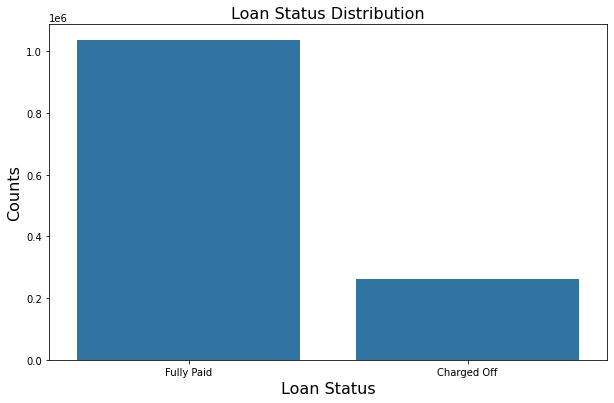

In [4]:
fontsize = 16
fig, ax = plt.subplots(figsize=[10, 10/1.62])

# Define the order of the grades and sub-grades
loan_status_order = sorted(loans_data['loan_status'].unique())[::-1]

# Plot the counts of each grade with hue set to 'loan_status'
sns.countplot(data=loans_data, x='loan_status', ax=ax, order=loan_status_order)
ax.set_xlabel(descriptions.loc['loan_status']['full_name'], fontsize=fontsize)
ax.set_ylabel('Counts', fontsize=fontsize)
ax.set_title('Loan Status Distribution', fontsize=fontsize)
# ax.legend(title=descriptions.loc['loan_status']['full_name'])

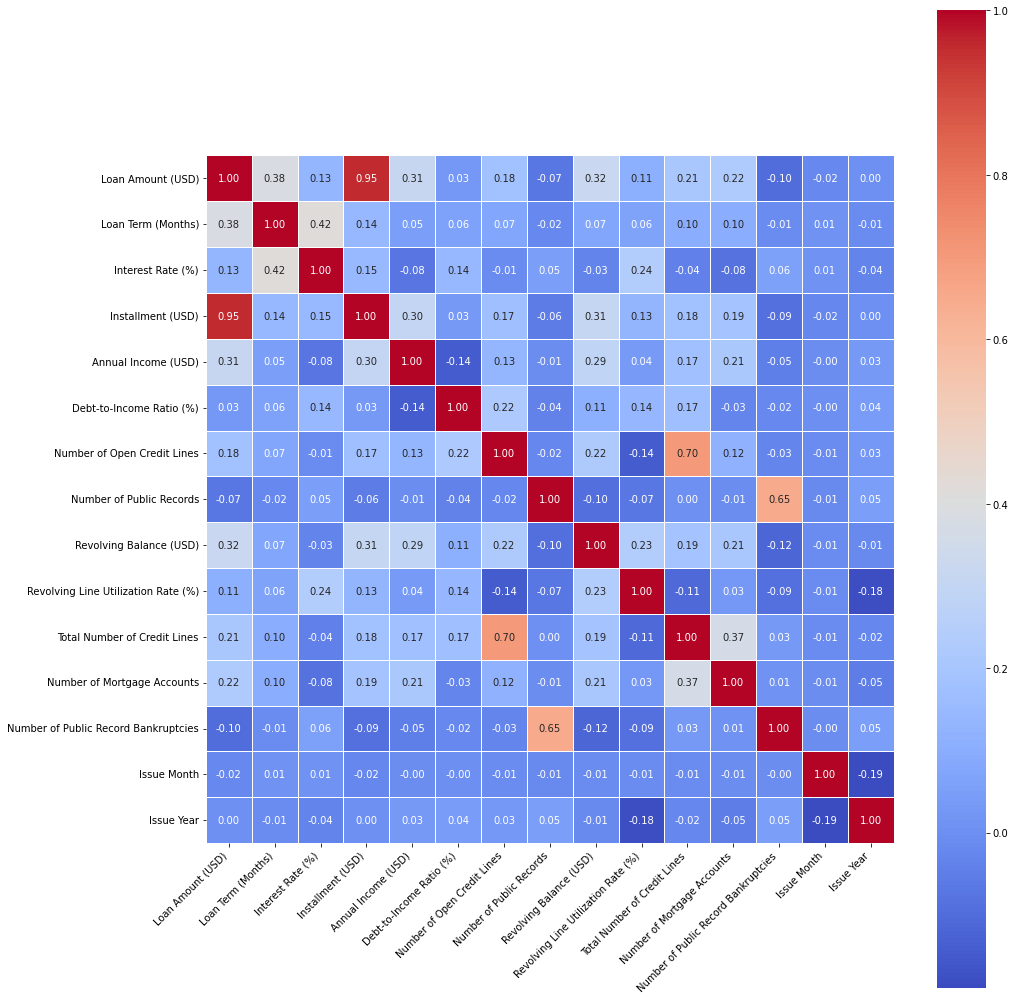

In [5]:
# Filter the DataFrame to include only numerical columns
numerical_data = loans_data.select_dtypes(include=['int64', 'float64'])

# Compute the correlation matrix
correlation_matrix = numerical_data.corr()

# Get the full names for each column
full_names = [descriptions.loc[col]['full_name'] for col in numerical_data.columns]

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(len(numerical_data.columns)*1, len(numerical_data.columns)*1))

# Draw the heatmap with the axis object
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, ax=ax)

# Set the tick labels as the full names
ax.set_xticklabels(full_names, rotation=45, ha="right")
ax.set_yticklabels(full_names, rotation=0)

fig.tight_layout()

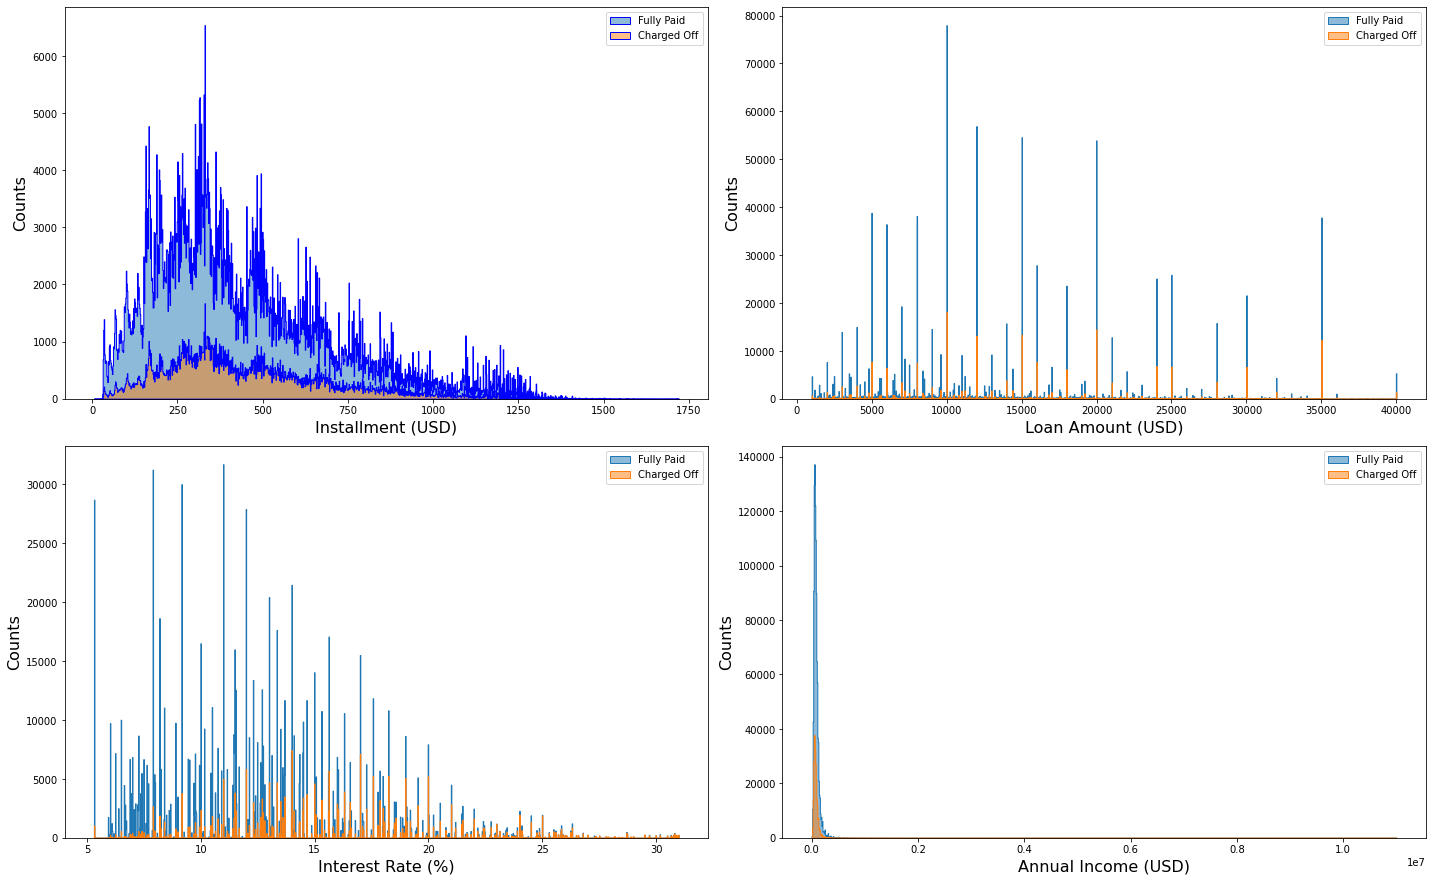

In [6]:
fontsize = 16

# Your existing setup
fig, axes = plt.subplots(2, 2, figsize=[20, 20/1.62])
loan_status_values = loans_data['loan_status'].unique()

# Histogram for 'installment'
bins_installment = np.linspace(loans_data['installment'].min(), loans_data['installment'].max(), int(np.sqrt(len(loans_data))))
for loan_status in loan_status_values:
    mask = loans_data['loan_status'] == loan_status
    sns.histplot(loans_data[mask]['installment'], label=loan_status, ax=axes[0, 0], element="step", bins=bins_installment, kde=False, alpha=0.5, edgecolor='b')
axes[0, 0].set_xlabel(descriptions.loc['installment']['full_name'], fontsize = fontsize)
axes[0, 0].set_ylabel('Counts', fontsize = fontsize)
axes[0, 0].legend()

# Histogram for 'loan_amnt'
bins_loan_amnt = np.linspace(loans_data['loan_amnt'].min(), loans_data['loan_amnt'].max(), int(np.sqrt(len(loans_data))))
for loan_status in loan_status_values:
    mask = loans_data['loan_status'] == loan_status
    sns.histplot(loans_data[mask]['loan_amnt'], label=loan_status, ax=axes[0, 1], element="step", bins=bins_loan_amnt, kde=False, alpha=0.5)
axes[0, 1].set_xlabel(descriptions.loc['loan_amnt']['full_name'], fontsize = fontsize)
axes[0, 1].set_ylabel('Counts', fontsize = fontsize)
axes[0, 1].legend()

# Histogram for 'int_rate'
bins_int_rate = np.linspace(loans_data['int_rate'].min(), loans_data['int_rate'].max(), int(np.sqrt(len(loans_data))))
for loan_status in loan_status_values:
    mask = loans_data['loan_status'] == loan_status
    sns.histplot(loans_data[mask]['int_rate'], label=loan_status, ax=axes[1, 0], element="step", bins=bins_int_rate, kde=False, alpha=0.5)
axes[1, 0].set_xlabel(descriptions.loc['int_rate']['full_name'], fontsize = fontsize)
axes[1, 0].set_ylabel('Counts', fontsize = fontsize)
axes[1, 0].legend()

# Histogram for 'annual_inc'
bins_annual_inc = np.linspace(loans_data['annual_inc'].min(), loans_data['annual_inc'].max(), int(np.sqrt(len(loans_data))))
for loan_status in loan_status_values:
    mask = loans_data['loan_status'] == loan_status
    sns.histplot(loans_data[mask]['annual_inc'], label=loan_status, ax=axes[1, 1], element="step", bins=bins_annual_inc, kde=False, alpha=0.5)
axes[1, 1].set_xlabel(descriptions.loc['annual_inc']['full_name'], fontsize = fontsize)
axes[1, 1].set_ylabel('Counts', fontsize = fontsize)
axes[1, 1].legend()

fig.tight_layout()

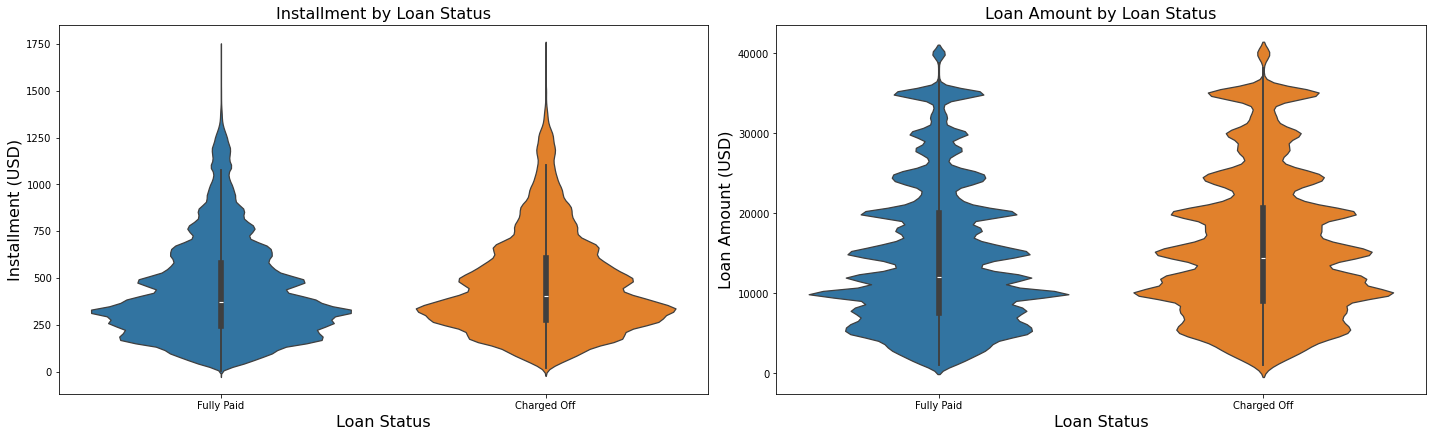

In [7]:
fontsize = 16

# Setup for the plots
fig, axes = plt.subplots(1, 2, figsize=[20, 10/1.62])

# Define the color palette to match the histogram colors

# Violin plot for 'installment'
sns.violinplot(x='loan_status', y='installment', hue='loan_status', data=loans_data, ax=axes[0])
axes[0].set_title('Installment by Loan Status', fontsize=fontsize)
axes[0].set_xlabel(descriptions.loc['loan_status']['full_name'], fontsize=fontsize)
axes[0].set_ylabel(descriptions.loc['installment']['full_name'], fontsize=fontsize)

# Violin plot for 'loan_amnt'
sns.violinplot(x='loan_status', y='loan_amnt', hue='loan_status', data=loans_data, ax=axes[1])
axes[1].set_title('Loan Amount by Loan Status', fontsize=fontsize)
axes[1].set_xlabel(descriptions.loc['loan_status']['full_name'], fontsize=fontsize)
axes[1].set_ylabel(descriptions.loc['loan_amnt']['full_name'], fontsize=fontsize)

plt.tight_layout()
plt.show()


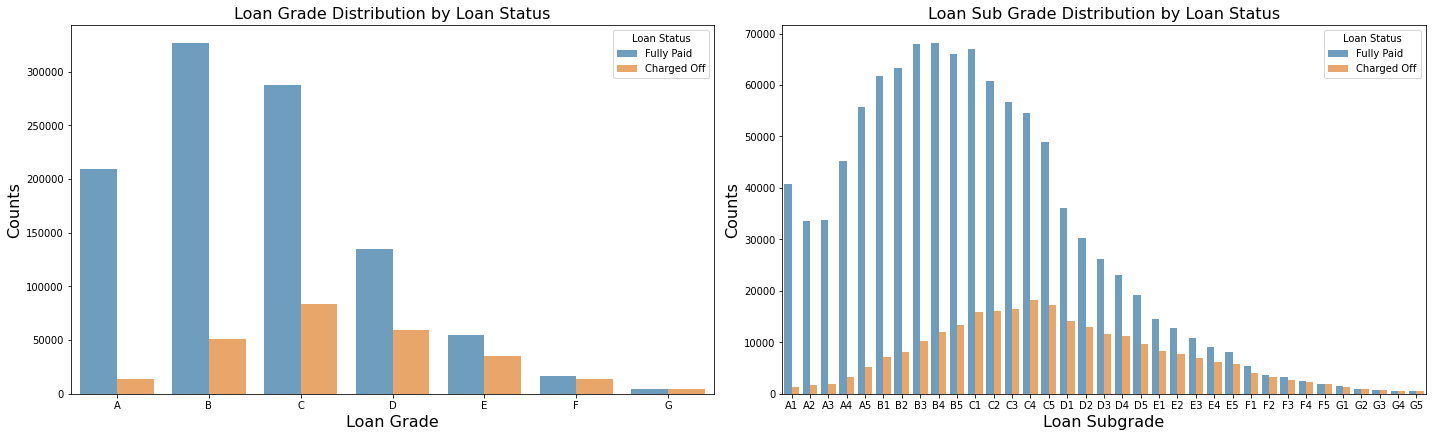

In [8]:
fontsize = 16
fig, axes = plt.subplots(1, 2, figsize=[20, 10/1.62])

grade_order = sorted(loans_data['grade'].unique())
sub_grade_order = sorted(loans_data['sub_grade'].unique())

sns.countplot(data=loans_data, x='grade', hue='loan_status', ax=axes[0], alpha=0.7, order=grade_order)
axes[0].set_xlabel(descriptions.loc['grade']['full_name'], fontsize=fontsize)
axes[0].set_ylabel('Counts', fontsize=fontsize)
axes[0].set_title('Loan Grade Distribution by Loan Status', fontsize=fontsize)
axes[0].legend(title=descriptions.loc['loan_status']['full_name'])

sns.countplot(data=loans_data, x='sub_grade', hue='loan_status', ax=axes[1], alpha=0.7, order=sub_grade_order)
axes[1].set_xlabel(descriptions.loc['sub_grade']['full_name'], fontsize=fontsize)
axes[1].set_ylabel('Counts', fontsize=fontsize)
axes[1].set_title('Loan Sub Grade Distribution by Loan Status', fontsize=fontsize)
axes[1].legend(title=descriptions.loc['loan_status']['full_name'])

fig.tight_layout()
plt.show()


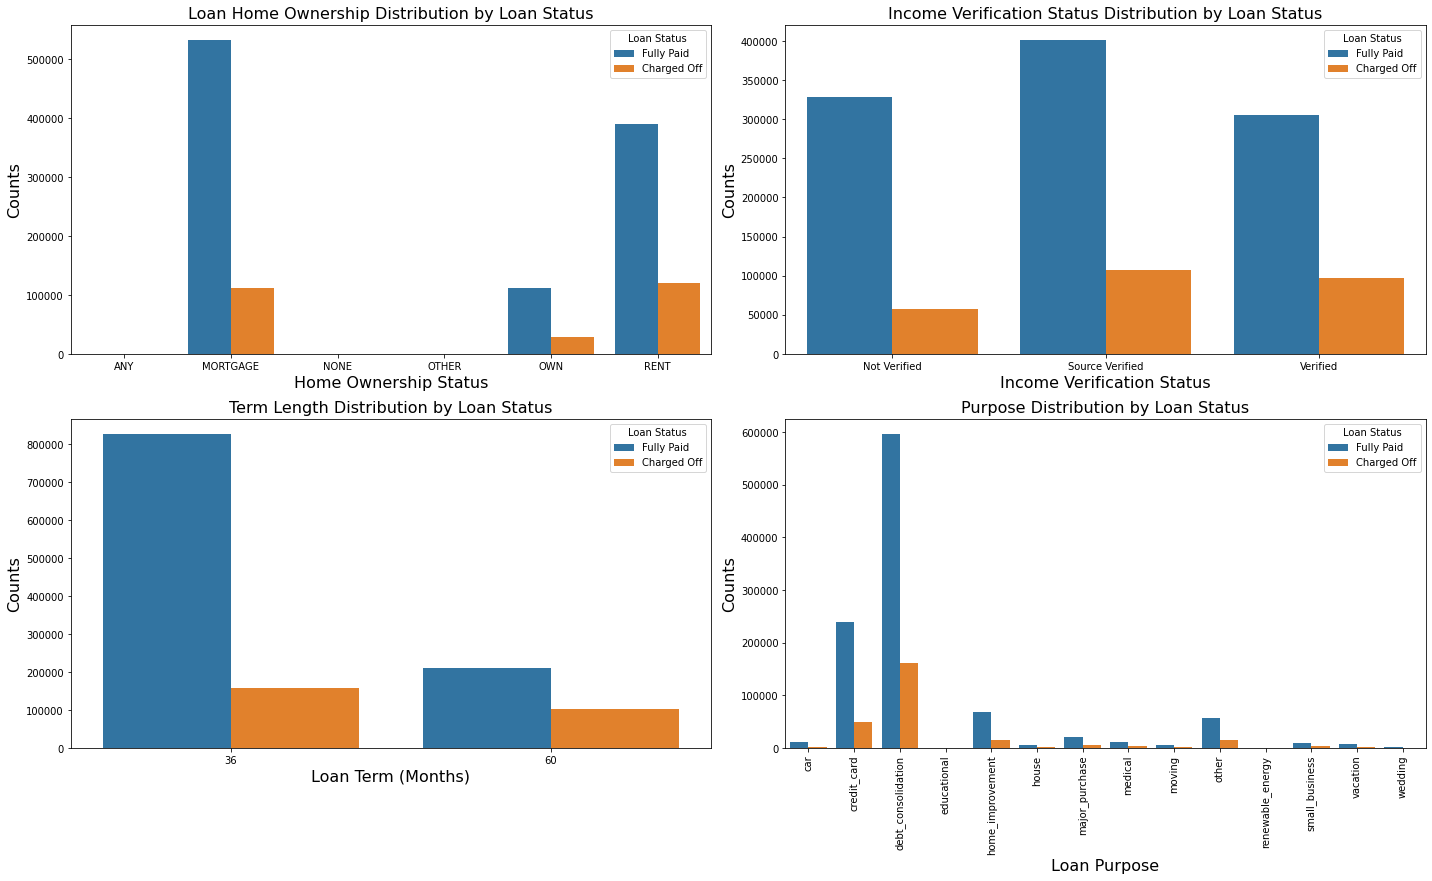

In [9]:
fontsize = 16
fig, ax = plt.subplots(2, 2, figsize=[20, 20/1.62])

home_ownership_order = sorted(loans_data['home_ownership'].unique())
verification_status_order = sorted(loans_data['verification_status'].unique())
term_months_order = sorted(loans_data['term_months'].unique())
purpose_order = sorted(loans_data['purpose'].unique())

sns.countplot(data=loans_data, x='home_ownership', hue='loan_status', ax=ax[0, 0], order=home_ownership_order)
ax[0, 0].set_xlabel(descriptions.loc['home_ownership']['full_name'], fontsize=fontsize)
ax[0, 0].set_ylabel('Counts', fontsize=fontsize)
ax[0, 0].set_title('Loan Home Ownership Distribution by Loan Status', fontsize=fontsize)
ax[0, 0].legend(title=descriptions.loc['loan_status']['full_name'])

sns.countplot(data=loans_data, x='verification_status', hue='loan_status', ax=ax[0, 1], order=verification_status_order)
ax[0, 1].set_xlabel(descriptions.loc['verification_status']['full_name'], fontsize=fontsize)
ax[0, 1].set_ylabel('Counts', fontsize=fontsize)
ax[0, 1].set_title('Income Verification Status Distribution by Loan Status', fontsize=fontsize)
ax[0, 1].legend(title=descriptions.loc['loan_status']['full_name'])

# Plot the counts of each grade with hue set to 'loan_status'
sns.countplot(data=loans_data, x='term_months', hue='loan_status', ax=ax[1, 0], order=term_months_order)
ax[1, 0].set_xlabel(descriptions.loc['term_months']['full_name'], fontsize=fontsize)
ax[1, 0].set_ylabel('Counts', fontsize=fontsize)
ax[1, 0].set_title('Term Length Distribution by Loan Status', fontsize=fontsize)
ax[1, 0].legend(title=descriptions.loc['loan_status']['full_name'])

# Plot the counts of each grade with hue set to 'loan_status'
sns.countplot(data=loans_data, x='purpose', hue='loan_status', ax=ax[1, 1], order=purpose_order)
ax[1, 1].set_xlabel(descriptions.loc['purpose']['full_name'], fontsize=fontsize)
ax[1, 1].set_ylabel('Counts', fontsize=fontsize)
ax[1, 1].set_title('Purpose Distribution by Loan Status', fontsize=fontsize)
ax[1, 1].legend(title=descriptions.loc['loan_status']['full_name'])
ax[1, 1].tick_params(axis='x', rotation=90)

fig.tight_layout()

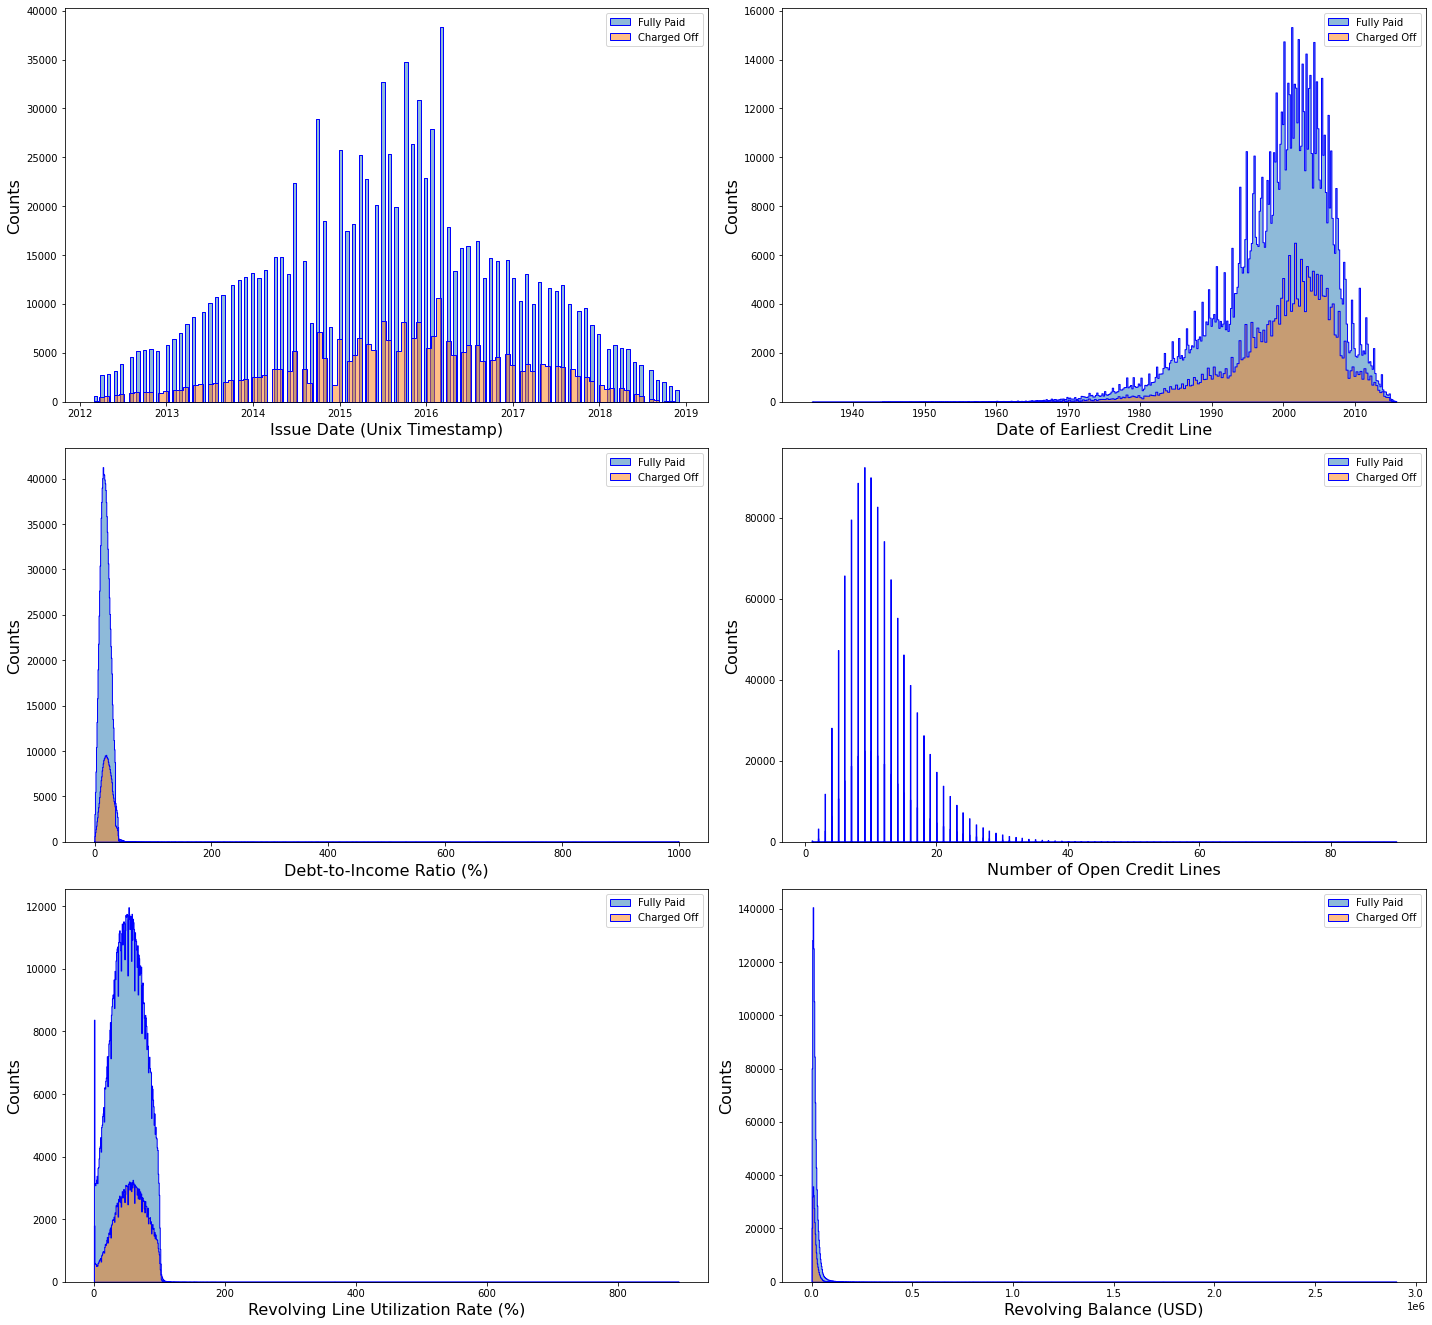

In [10]:
loan_status_values = loans_data['loan_status'].unique()

fig, ax = plt.subplots(3, 2, figsize = [20, 30/1.62])

for loan_status in loan_status_values:
    mask = loans_data['loan_status'] == loan_status
    sns.histplot(loans_data[mask]['issue_d'], label=loan_status, ax=ax[0, 0], element="step", kde=False, alpha=0.5, edgecolor='b')
ax[0, 0].set_xlabel(descriptions.loc['issue_d_unix']['full_name'], fontsize = fontsize)
ax[0, 0].set_ylabel('Counts', fontsize = fontsize)
ax[0, 0].legend()

for loan_status in loan_status_values:
    mask = loans_data['loan_status'] == loan_status
    sns.histplot(loans_data[mask]['earliest_cr_line'], label=loan_status, ax=ax[0, 1], element="step", kde=False, alpha=0.5, edgecolor='b')
ax[0, 1].set_xlabel(descriptions.loc['earliest_cr_line']['full_name'], fontsize = fontsize)
ax[0, 1].set_ylabel('Counts', fontsize = fontsize)
ax[0, 1].legend()

bins_dti = np.linspace(loans_data['dti'].min(), loans_data['dti'].max(), int(np.sqrt(len(loans_data))))
for loan_status in loan_status_values:
    mask = loans_data['loan_status'] == loan_status
    sns.histplot(loans_data[mask]['dti'], label=loan_status, ax=ax[1, 0], element="step", bins=bins_dti, kde=False, alpha=0.5, edgecolor='b')
ax[1, 0].set_xlabel(descriptions.loc['dti']['full_name'], fontsize = fontsize)
ax[1, 0].set_ylabel('Counts', fontsize = fontsize)
ax[1, 0].legend()

bins_open_acc = np.linspace(loans_data['open_acc'].min(), loans_data['open_acc'].max(), int(np.sqrt(len(loans_data))))
for loan_status in loan_status_values:
    mask = loans_data['loan_status'] == loan_status
    sns.histplot(loans_data[mask]['open_acc'], label=loan_status, ax=ax[1, 1], element="step", bins=bins_open_acc, kde=False, alpha=0.5, edgecolor='b')
ax[1, 1].set_xlabel(descriptions.loc['open_acc']['full_name'], fontsize = fontsize)
ax[1, 1].set_ylabel('Counts', fontsize = fontsize)
ax[1, 1].legend()

bins_revol_util = np.linspace(loans_data['revol_util'].min(), loans_data['revol_util'].max(), int(np.sqrt(len(loans_data))))
for loan_status in loan_status_values:
    mask = loans_data['loan_status'] == loan_status
    sns.histplot(loans_data[mask]['revol_util'], label=loan_status, ax=ax[2, 0], element="step",bins=bins_revol_util, kde=False, alpha=0.5, edgecolor='b')
ax[2, 0].set_xlabel(descriptions.loc['revol_util']['full_name'], fontsize = fontsize)
ax[2, 0].set_ylabel('Counts', fontsize = fontsize)
ax[2, 0].legend()

bins_revol_bal = np.linspace(loans_data['revol_bal'].min(), loans_data['revol_bal'].max(), int(np.sqrt(len(loans_data))))
for loan_status in loan_status_values:
    mask = loans_data['loan_status'] == loan_status
    sns.histplot(loans_data[mask]['revol_bal'], label=loan_status, ax=ax[2, 1], element="step",bins=bins_revol_bal, kde=False, alpha=0.5, edgecolor='b')
ax[2, 1].set_xlabel(descriptions.loc['revol_bal']['full_name'], fontsize = fontsize)
ax[2, 1].set_ylabel('Counts', fontsize = fontsize)
ax[2, 1].legend()

fig.tight_layout()

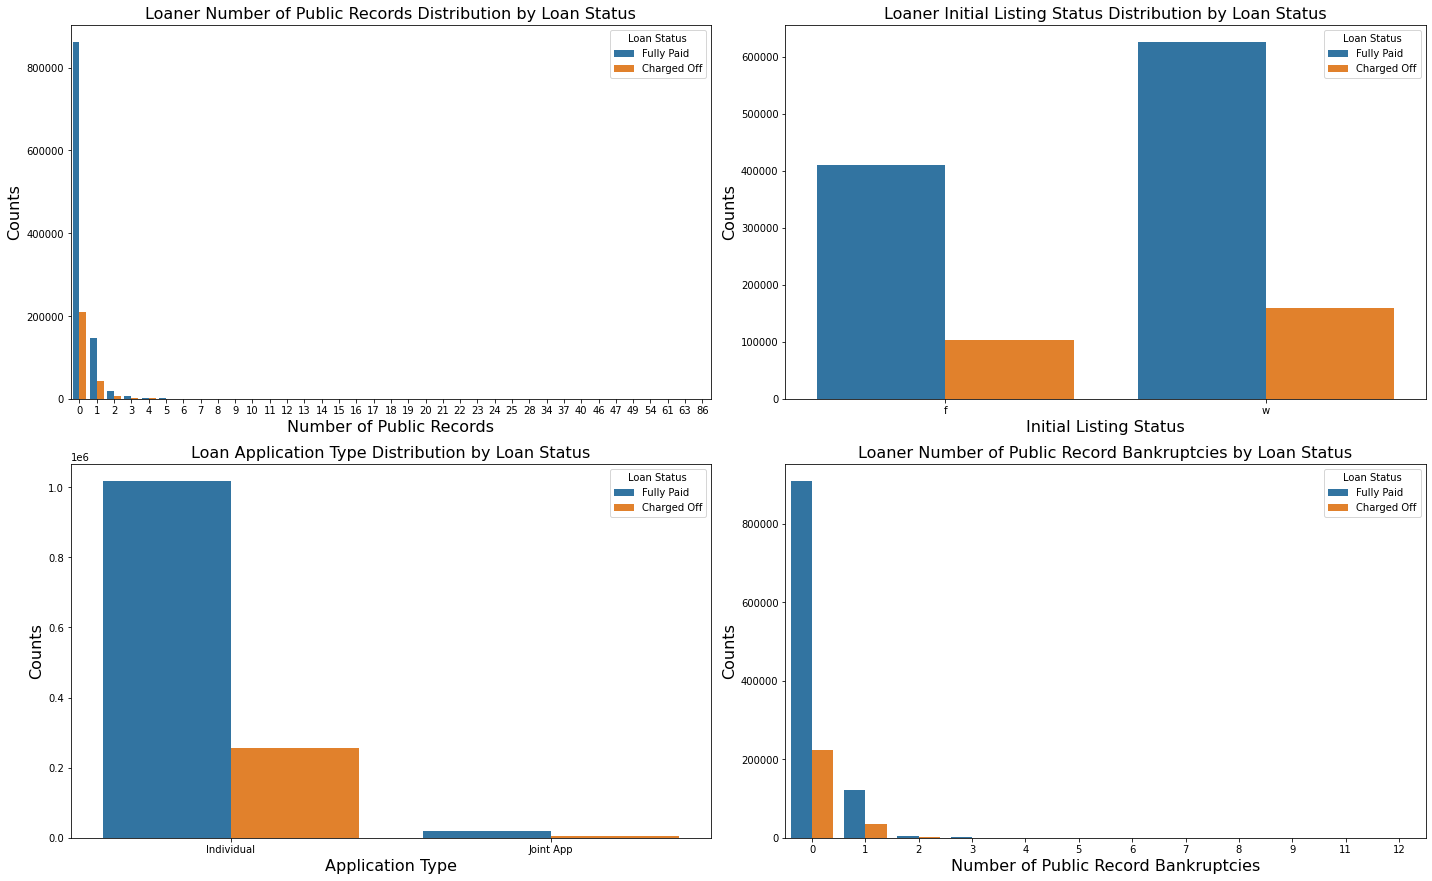

In [11]:
fontsize = 16
fig, ax = plt.subplots(2, 2, figsize=[20, 20/1.62])

pub_rec_order = sorted(loans_data['pub_rec'].unique())

sns.countplot(data=loans_data, x='pub_rec', hue='loan_status', ax=ax[0, 0], order=pub_rec_order)
ax[0, 0].set_xlabel(descriptions.loc['pub_rec']['full_name'], fontsize=fontsize)
ax[0, 0].set_ylabel('Counts', fontsize=fontsize)
ax[0, 0].set_title('Loaner Number of Public Records Distribution by Loan Status', fontsize=fontsize)
ax[0, 0].legend(title=descriptions.loc['loan_status']['full_name'])

initial_list_status_order = sorted(loans_data['initial_list_status'].unique())

sns.countplot(data=loans_data, x='initial_list_status', hue='loan_status', ax=ax[0, 1], order=initial_list_status_order)
ax[0, 1].set_xlabel(descriptions.loc['initial_list_status']['full_name'], fontsize=fontsize)
ax[0, 1].set_ylabel('Counts', fontsize=fontsize)
ax[0, 1].set_title('Loaner Initial Listing Status Distribution by Loan Status', fontsize=fontsize)
ax[0, 1].legend(title=descriptions.loc['loan_status']['full_name'])

application_type_order = sorted(loans_data['application_type'].unique())

sns.countplot(data=loans_data, x='application_type', hue='loan_status', ax=ax[1, 0], order=application_type_order)
ax[1, 0].set_xlabel(descriptions.loc['application_type']['full_name'], fontsize=fontsize)
ax[1, 0].set_ylabel('Counts', fontsize=fontsize)
ax[1, 0].set_title('Loan Application Type Distribution by Loan Status', fontsize=fontsize)
ax[1, 0].legend(title=descriptions.loc['loan_status']['full_name'])

pub_rec_bankruptcies_order = sorted(loans_data['pub_rec_bankruptcies'].unique())

sns.countplot(data=loans_data, x='pub_rec_bankruptcies', hue='loan_status', ax=ax[1, 1], order=pub_rec_bankruptcies_order)
ax[1, 1].set_xlabel(descriptions.loc['pub_rec_bankruptcies']['full_name'], fontsize=fontsize)
ax[1, 1].set_ylabel('Counts', fontsize=fontsize)
ax[1, 1].set_title('Loaner Number of Public Record Bankruptcies by Loan Status', fontsize=fontsize)
ax[1, 1].legend(title=descriptions.loc['loan_status']['full_name'])

fig.tight_layout()

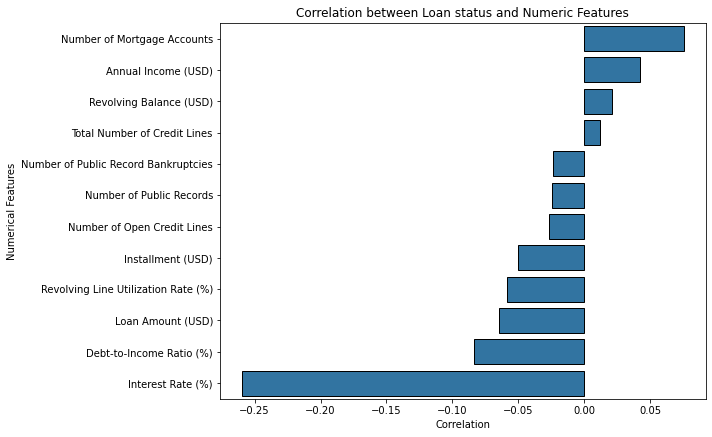

In [12]:
loans_data['loan_status_num'] = loans_data['loan_status'].apply(lambda x: 0 if x == 'Charged Off' else 1)

num_cols = ['mort_acc', 'annual_inc', 'loan_status_num', 'total_acc', 'revol_bal', 'pub_rec_bankruptcies', 'pub_rec', 'open_acc', 'installment', 'loan_amnt', 'dti', 'revol_util', 'int_rate']

correlation = loans_data[num_cols].corr()['loan_status_num'].drop('loan_status_num').sort_values().iloc[::-1]

full_names_map = {col: descriptions.loc[col]['full_name'] for col in num_cols if col in descriptions.index}

full_names_map['loan_status_num'] = 'Numerical Loan Status'  # Replace with the actual full name

correlation.index = [full_names_map.get(col, col) for col in correlation.index]

fig, ax = plt.subplots(figsize=[10, 10/1.62])
sns.barplot(x=correlation.values, y=correlation.index, edgecolor="black", ax=ax)

ax.set_title("Correlation between Loan status and Numeric Features")
ax.set_xlabel('Correlation')
ax.set_ylabel('Numerical Features')

fig.tight_layout()


## 3 - Data PreProcessing

In [13]:
print(f"Lenght of Dataset: {loans_data.shape}")
print("--------------------------------------")
print("Quantity of missing values\n")

# Minimum accepted percentage of values missing for a column to be useful
thresh = 5
# List of columns to drop
drop_columns = []
# List of column to ignore missing values from
dropna_columns = []
for column in loans_data.columns:
    if loans_data[column].isna().sum() != 0:
        missing = loans_data[column].isna().sum()
        portion = (missing / loans_data.shape[0]) * 100
        print(f"{column} | {descriptions.loc[column]['full_name']}: number of missing values: {missing} -> {portion:.3f}%")
        if portion >= thresh:
            drop_columns += [column]
        else:
            dropna_columns += [column]
            
print(f"\nColumns to be dropped: {', '.join(drop_columns)}")
print(f"\nColumns to ignore missing data from: {', '.join(dropna_columns)}\n")

loans_data.drop(drop_columns, axis='columns', inplace=True)
loans_data.dropna(subset=dropna_columns, inplace=True)

print(f"Adjusted lenght of Dataset: {loans_data.shape}")

print("--------------------------------------")

Lenght of Dataset: (1296861, 27)
--------------------------------------
Quantity of missing values


Columns to be dropped: 

Columns to ignore missing data from: 

Adjusted lenght of Dataset: (1296861, 27)
--------------------------------------


## 4 - Creting Categorical and Dummy Variables

In [14]:
print([column for column in loans_data.columns if loans_data[column].dtype == object])

['grade', 'sub_grade', 'home_ownership', 'verification_status', 'issue_d_unix', 'loan_status', 'purpose', 'initial_list_status', 'application_type']


In [15]:
# List of columns to drop and we won't care about
columns_to_drop = []
columns_to_drop += ['grade'] # It's redundant, since sub_grade has information about it

# The rest will become dummy variables
dummies = [column for column in loans_data.columns if loans_data[column].dtype == object and column not in columns_to_drop and column != 'loan_status']
# We'll also add the month and year the loan was issued as dummy variables
dummies += ['issue_month', 'issue_year']
# Dropping proper columns
loans_data.drop(columns_to_drop, axis='columns', inplace=True)
# Creating dummy variables in dataframe
loans_data = pd.get_dummies(loans_data, columns=dummies, drop_first=True)

loans_data

,loan_amnt,term_months,int_rate,installment,annual_inc,loan_status,dti,earliest_cr_line,open_acc,pub_rec,...,issue_month_9,issue_month_10,issue_month_11,issue_month_12,issue_year_2013,issue_year_2014,issue_year_2015,issue_year_2016,issue_year_2017,issue_year_2018
id,,,,,,,,,,,,,,,,,,,,,
1861736,18250,36,11.14,598.70,43000,Fully Paid,12.45,2000-03-01,3,0,...,False,False,False,False,True,False,False,False,False,False
2205498,7500,36,16.99,267.36,109000,Fully Paid,30.78,1998-10-01,12,0,...,False,False,True,False,False,False,False,True,False,False
403322,11350,36,13.66,386.05,31629,Fully Paid,11.65,2008-02-01,6,0,...,False,False,False,False,False,False,True,False,False,False
1221008,5000,36,10.15,161.69,39000,Charged Off,14.58,2006-09-01,28,0,...,False,False,False,False,False,True,False,False,False,False
1151138,5000,36,16.99,178.24,38750,Fully Paid,19.17,2001-03-01,10,0,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234398,12000,36,13.33,406.24,75000,Charged Off,15.06,2000-11-01,12,0,...,False,False,False,False,False,False,True,False,False,False
388979,7000,36,11.44,230.64,23000,Fully Paid,20.09,1996-07-01,10,0,...,False,False,False,False,False,False,True,False,False,False
1911961,35000,36,7.90,1095.16,100000,Fully Paid,16.82,1994-11-01,13,0,...,False,False,False,False,False,False,False,False,False,False


## 5 - Training ML Algorithms

In [16]:
ML_columns = [column for column in loans_data.columns if loans_data[column].dtype == int or loans_data[column].dtype == float or loans_data[column].dtype == bool]
w_p = loans_data['loan_status_num'].value_counts()[0] / loans_data.shape[0]
w_n = loans_data['loan_status_num'].value_counts()[1] / loans_data.shape[0]

print(f"Weight of positive values {w_p}")
print(f"Weight of negative values {w_n}")

Weight of positive values 0.20159600759063617
Weight of negative values 0.7984039924093639


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import learning_curve, RandomizedSearchCV

sample_data = loans_data.sample(20000)
# Defining inputs and outputs of dataset
X = sample_data[ML_columns].drop('loan_status_num', axis='columns').values
y = np.vstack(sample_data[ML_columns]['loan_status_num'].values)
# Splitting between trainnig and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of training inputs: {X_train.shape}")
print(f"Shape of testing inputs: {X_test.shape}")
print(f"Shape of training outputs: {y_train.shape}")
print(f"Shape of testing outputs: {y_test.shape}")

# Scaling the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_X.fit(X)
X_train = scaler_X.transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y.fit(y)
y_train = scaler_y.transform(y_train)
y_test = scaler_y.transform(y_test)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

Shape of training inputs: (16000, 167)
Shape of testing inputs: (4000, 167)
Shape of training outputs: (16000, 1)
Shape of testing outputs: (4000, 1)


### 5.1 Logistic Regression

#### 5.1.1 Example Algorithm

Accuracy: 0.6435
              precision    recall  f1-score   support

         0.0       0.30      0.62      0.41       790
         1.0       0.87      0.65      0.75      3210

    accuracy                           0.64      4000
   macro avg       0.59      0.63      0.58      4000
weighted avg       0.76      0.64      0.68      4000



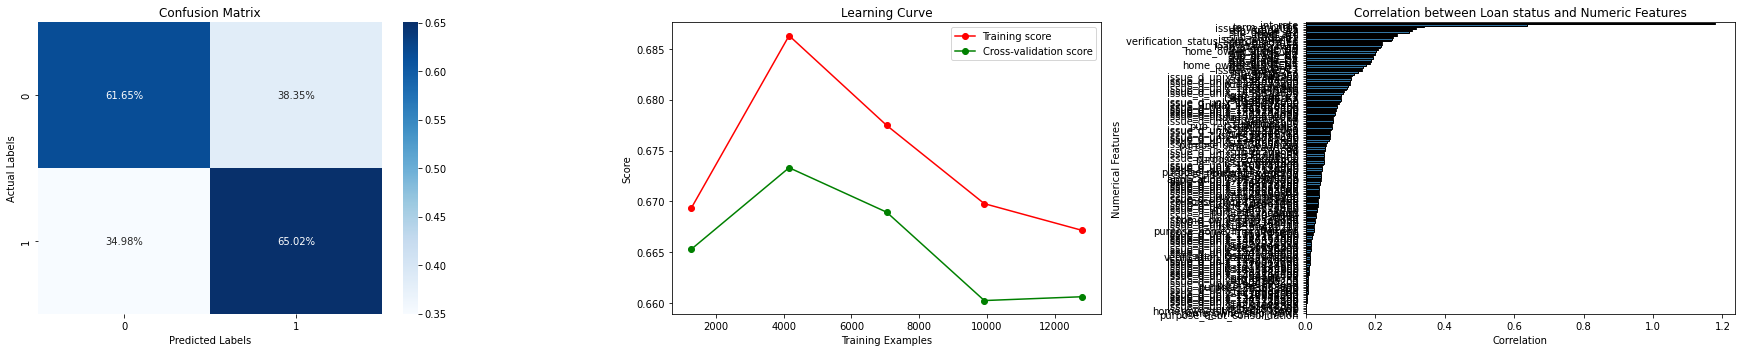

In [29]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
logistic_model = LogisticRegression(class_weight='balanced', max_iter=1000, C=0.01)

# Train the model
logistic_model.fit(X_train, y_train)

# Make predictions
y_pred = logistic_model.predict(X_test)

train_sizes, train_scores, test_scores = learning_curve(
    logistic_model, X_train, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))

coefficients = np.abs(logistic_model.coef_[0])

# Combining feature names and their corresponding coefficients
features, coefs = zip(*sorted(zip(ML_columns, coefficients), key=lambda x: x[1], reverse=True))

fig, ax = plt.subplots(1, 3, figsize = [15*1.62, 5])

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizing the confusion matrix

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_ylabel('Actual Labels')
ax[0].set_xlabel('Predicted Labels')

ax[1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax[1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax[1].set_title('Learning Curve')
ax[1].set_xlabel('Training Examples')
ax[1].set_ylabel('Score')
ax[1].legend(loc="best")

sns.barplot(x=coefs, y=features, edgecolor="black", ax=ax[2])
ax[2].set_title("Correlation between Loan status and Numeric Features")
ax[2].set_xlabel('Correlation')
ax[2].set_ylabel('Numerical Features')

fig.tight_layout()

#### 5.1.2 Hyperparameter Search

In [44]:
import sys
import os

import warnings

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    # Since we're setting this at the sys level, it should not be overridden
    os.environ["PYTHONWARNINGS"] = "ignore"  # Also affect subprocesses

from sklearn.exceptions import FitFailedWarning

warnings.filterwarnings('ignore', category=UserWarning)

warnings.filterwarnings('ignore', category=UserWarning, message="Setting penalty=None will ignore the C and l1_ratio parameters")

warnings.filterwarnings('ignore', category=FitFailedWarning)

warnings.filterwarnings('ignore', message="l1_ratio parameter is only used when penalty is 'elasticnet'")

warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.linear_model._logistic')

warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.linear_model')

warnings.filterwarnings('ignore', '.*l1_ratio parameter is only used when penalty is \'elasticnet\'.*')

warnings.filterwarnings('ignore', category=UserWarning)

import matplotlib
matplotlib.use('Agg')

print("Starting Hyperparameter optimization run for Logistic Model")

n_reps = 5
max_iter = 10000

print(f"Number of repetitions: {n_reps}")

param_dist = {
    'C': [10**i for i in np.linspace(-3, 3, num=100)],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l2', 'l1', 'elasticnet', None],
    'l1_ratio': np.linspace(0, 1, num=10),
}

logistic_model = LogisticRegression(class_weight='balanced', max_iter=max_iter)

random_search = RandomizedSearchCV(logistic_model, param_distributions=param_dist, n_iter=n_reps, cv=5, random_state=42, verbose=10, error_score=np.nan)

print("Fitting Random Search")
random_search.fit(X_train, y_train)

param_combination_details = []

for i, (params, mean_test_score) in enumerate(zip(random_search.cv_results_['params'], random_search.cv_results_['mean_test_score']), 1):
    try:
        print(f"Model ID: {i}")
        print(f"Parameters: {params}")

        current_model = random_search.best_estimator_.set_params(**params)

        # Calculate learning curve data
        train_sizes, train_scores, test_scores = learning_curve(
            current_model, X_train, y_train, cv=5, n_jobs=-1, 
            train_sizes=np.linspace(.1, 1.0, 5))

        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        current_model.fit(X_train, y_train)

        y_pred = current_model.predict(X_test)

        coefficients = np.abs(current_model.coef_[0])

        features, coefs = zip(*sorted(zip(ML_columns, coefficients), key=lambda x: x[1], reverse=True))

        cm = confusion_matrix(y_test, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizing the confusion matrix

        fig, ax = plt.subplots(1, 3, figsize = [15*1.62, 5])

        sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax[0])
        ax[0].set_title('Confusion Matrix')
        ax[0].set_ylabel('Actual Labels')
        ax[0].set_xlabel('Predicted Labels')

        ax[1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        ax[1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        ax[1].set_title('Learning Curve')
        ax[1].set_xlabel('Training Examples')
        ax[1].set_ylabel('Score')
        ax[1].legend(loc="best")

        sns.barplot(x=coefs, y=features, edgecolor="black", ax=ax[2])
        ax[2].set_title("Correlation between Loan status and Numeric Features")
        ax[2].set_xlabel('Correlation')
        ax[2].set_ylabel('Numerical Features')

        fig_path = f"../figures/LogisticRegression_{str(i).zfill(len(str(n_reps)))}.png"
        fig.savefig(fig_path)
        plt.close(fig)
        param_combination_details.append({
            'id': i,
            'params': params,
            'accuracy': mean_test_score,
            'figure_path': fig_path
        })
        print(f"Accuracy:{mean_test_score}\n------------------------")
    except:
        print("Likely Bad Combination?")
param_combination_df = pd.DataFrame(param_combination_details)
param_combination_df.to_csv('../data/LogisticRegression_RandomizedSearchCV.csv', index=False)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")

Starting Hyperparameter optimization run for Logistic Model
Number of repetitions: 5
Fitting Random Search
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START C=284.8035868435805, l1_ratio=0.8888888888888888, penalty=None, solver=liblinear
[CV 1/5; 1/5] END C=284.8035868435805, l1_ratio=0.8888888888888888, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 1/5] START C=284.8035868435805, l1_ratio=0.8888888888888888, penalty=None, solver=liblinear
[CV 2/5; 1/5] END C=284.8035868435805, l1_ratio=0.8888888888888888, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 1/5] START C=284.8035868435805, l1_ratio=0.8888888888888888, penalty=None, solver=liblinear
[CV 3/5; 1/5] END C=284.8035868435805, l1_ratio=0.8888888888888888, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 1/5] START C=284.8035868435805, l1_ratio=0.8888888888888888, penalty=None, solver=liblinear
[CV 4/5; 1/5] END C=284.8035868435805, 

In [38]:
params

{'solver': 'liblinear',
 'penalty': None,
 'l1_ratio': 0.8888888888888888,
 'C': 284.8035868435805}

Accuracy: 0.8004626546563387
              precision    recall  f1-score   support

         0.0       0.54      0.08      0.14     86374
         1.0       0.81      0.98      0.89    341591

    accuracy                           0.80    427965
   macro avg       0.67      0.53      0.51    427965
weighted avg       0.75      0.80      0.74    427965



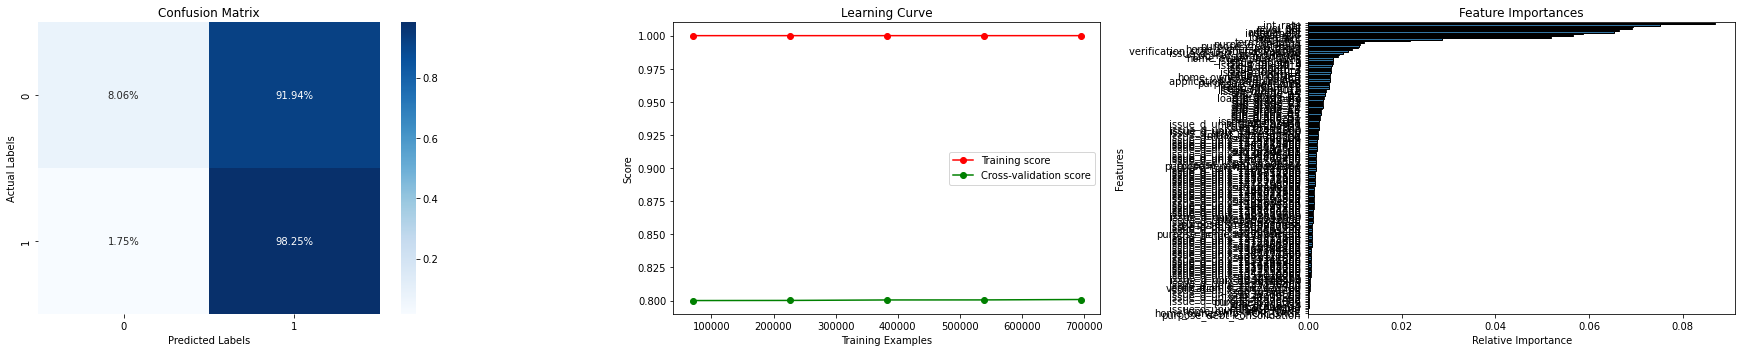

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForest model
rf_model = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Accuracy and Classification Report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature Importances
feature_importances = abs(rf_model.feature_importances_)

# Combining feature names and their corresponding importances
features, importances = zip(*sorted(zip(ML_columns, feature_importances), key=lambda x: x[1], reverse=True))

# Plotting
fig, ax = plt.subplots(1, 3, figsize=[15*1.62, 5])

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_ylabel('Actual Labels')
ax[0].set_xlabel('Predicted Labels')

# Learning Curve
ax[1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax[1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax[1].set_title('Learning Curve')
ax[1].set_xlabel('Training Examples')
ax[1].set_ylabel('Score')
ax[1].legend(loc="best")

# Feature Importances
sns.barplot(x=importances, y=features, edgecolor="black", ax=ax[2])
ax[2].set_title("Feature Importances")
ax[2].set_xlabel('Relative Importance')
ax[2].set_ylabel('Features')

fig.tight_layout()

/Users/andreguimaraes/opt/anaconda3/envs/FinancialEnv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreguimaraes/opt/anaconda3/envs/FinancialEnv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreguimaraes/opt/anaconda3/envs/FinancialEnv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreguimaraes/opt/anaconda3/envs/FinancialEnv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum i

Accuracy: 0.7998598016192913
              precision    recall  f1-score   support

         0.0       0.52      0.10      0.17     86374
         1.0       0.81      0.98      0.89    341591

    accuracy                           0.80    427965
   macro avg       0.67      0.54      0.53    427965
weighted avg       0.75      0.80      0.74    427965



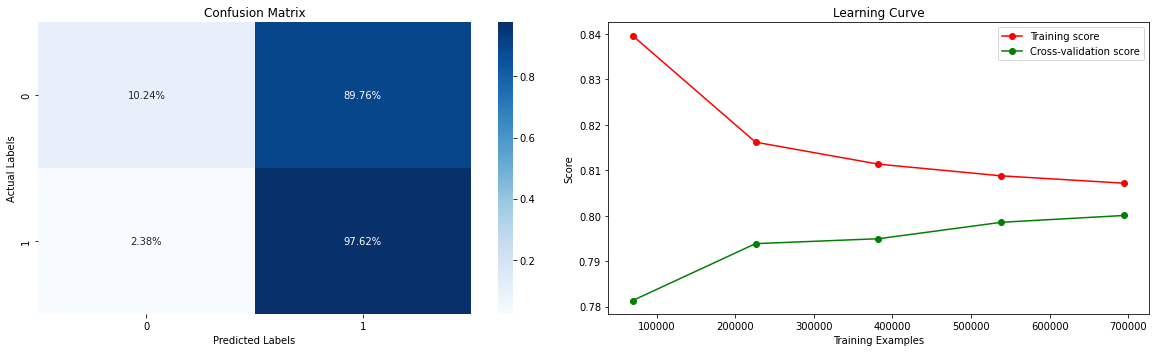

In [20]:
from sklearn.neural_network import MLPClassifier

# Assuming X_train, X_test, y_train, y_test are already defined

# Initialize the MLPClassifier model
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', 
                          max_iter=100, random_state=42)

# Train the model
mlp_model.fit(X_train, y_train)

# Make predictions
y_pred = mlp_model.predict(X_test)

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    mlp_model, X_train, y_train, cv=5, train_sizes=np.linspace(.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Accuracy and Classification Report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting
fig, ax = plt.subplots(1, 2, figsize=[10*1.62, 5])  # Reduced to 1x2 layout

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_ylabel('Actual Labels')
ax[0].set_xlabel('Predicted Labels')

# Learning Curve
ax[1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax[1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax[1].set_title('Learning Curve')
ax[1].set_xlabel('Training Examples')
ax[1].set_ylabel('Score')
ax[1].legend(loc="best")

fig.tight_layout()
